In [1]:
import skimage 
from skimage.util import img_as_ubyte
from skimage import data
import rasterio as rs
from rasterio.plot import show
import hickle as hkl
import os
import scipy
from scipy import ndimage
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [17]:
def remove_small_patches(arr, thresh):
    
    '''
    Label features in an array using ndimage.label()
    (option to add a 3x3 structure which considers features connected even 
    if they touch diagonally - probably dnt want this)
    
    '''
    start_unique, start_counts = np.unique(arr, return_counts=True)
    
    # creates arr where each unique feature (non zero value) has a unique label
    # num features are the number of connected patches
    labeled_array, num_features = ndimage.label(arr)

    # get pixel count for each label
    label_size = [(labeled_array == label).sum() for label in range(num_features + 1)]

    # if the count of pixels doesn't meet the threshold, make label 0
    for label,size in enumerate(label_size):
        if size < thresh:
            arr[labeled_array == label] = 0
            end_unique, end_counts = np.unique(arr, return_counts=True)
            
#     print(f'Start count: {dict(zip(start_unique, start_counts))}')
#     print(f'End count: {dict(zip(end_unique, end_counts))}')
    
    return arr

In [38]:
# import an array
raw_arr = rs.open('../tmp/ghana/preds/1648X1081Y_preds.tif').read(1)
unique, counts = np.unique(raw_arr, return_counts=True)
dict(zip(unique, counts))

{0: 93614, 1: 10634, 2: 275204}

In [39]:
# creates an array 
postprocess_mono = remove_small_patches(raw_arr == 1, thresh = 20)
postprocess_af = remove_small_patches(raw_arr == 2, thresh = 15)

Start count: {False: 368818, True: 10634}
End count: {False: 373370, True: 6082}
Start count: {False: 104248, True: 275204}
End count: {False: 105016, True: 274436}


In [41]:
# multiplying by boolean will turn every False into 0 
# and keep every True as the original label
raw_arr[raw_arr == 1] *= postprocess_mono[raw_arr == 1]
raw_arr[raw_arr == 2] *= postprocess_af[raw_arr == 2]
unique, counts = np.unique(raw_arr, return_counts=True)
dict(zip(unique, counts))

{0: 98934, 1: 6082, 2: 274436}

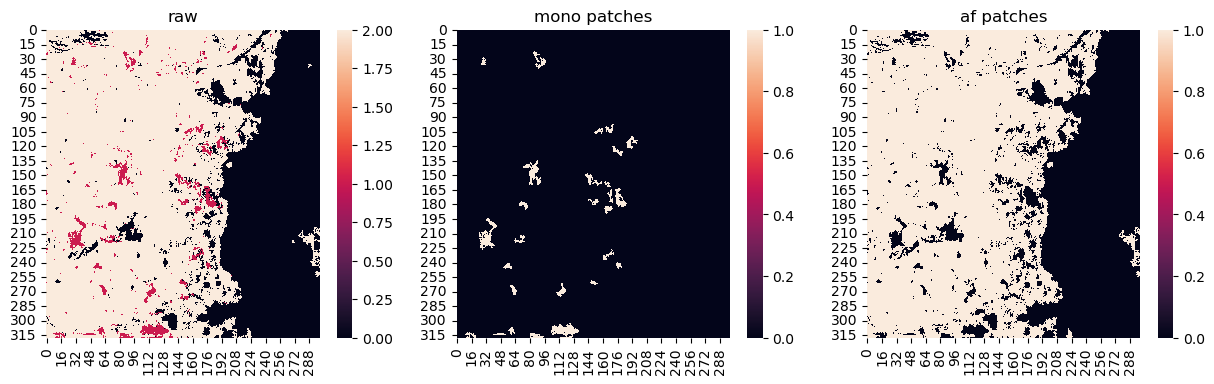

In [37]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
sns.heatmap(raw_arr[300:, 200:500]).set_title('raw')
plt.subplot(1,3,2)
sns.heatmap(mono[300:, 200:500]).set_title('mono patches')
plt.subplot(1,3,3)
sns.heatmap(af[300:, 200:500]).set_title('af patches');